In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [2]:

df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')
df

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



country_region_code        country_region       sub_region_1  \
0                        AE  United Arab Emirates                NaN   
1                        AE  United Arab Emirates                NaN   
2                        AE  United Arab Emirates                NaN   
3                        AE  United Arab Emirates                NaN   
4                        AE  United Arab Emirates                NaN   
...                     ...                   ...                ...   
5148181                  ZW              Zimbabwe  Midlands Province   
5148182                  ZW              Zimbabwe  Midlands Province   
5148183                  ZW              Zimbabwe  Midlands Province   
5148184                  ZW              Zimbabwe  Midlands Province   
5148185                  ZW              Zimbabwe  Midlands Province   

        sub_region_2 metro_area iso_3166_2_code  census_fips_code  \
0                NaN        NaN             NaN               NaN   
1                NaN        NaN             NaN               NaN   
2                NaN        NaN             NaN               NaN   
3                NaN        NaN             NaN               NaN   
4                NaN        NaN             NaN               NaN   
...              ...        ...             ...               ...   
5148181       Kwekwe        NaN             NaN               NaN   
5148182       Kwekwe        NaN             NaN               NaN   
5148183       Kwekwe        NaN             NaN               NaN   
5148184       Kwekwe        NaN             NaN               NaN   
5148185       Kwekwe        NaN             NaN               NaN   

                            place_id        date  \
0        ChIJvRKrsd9IXj4RpwoIwFYv0zM  2020-02-15   
1        ChIJvRKrsd9IXj4RpwoIwFYv0zM  2020-02-16   
2        ChIJvRKrsd9IXj4RpwoIwFYv0zM  2020-02-17   
3        ChIJvRKrsd9IXj4RpwoIwFYv0zM  2020-02-18   
4        ChIJvRKrsd9IXj4RpwoIwFYv0zM  2020-02-19   
...                              ...         ...   
5148181  ChIJRcIZ3-FJNBkRRsj55IcLpfU  2021-04-19   
5148182  ChIJRcIZ3-FJNBkRRsj55IcLpfU  2021-04-20   
5148183  ChIJRcIZ3-FJNBkRRsj55IcLpfU  2021-04-21   
5148184  ChIJRcIZ3-FJNBkRRsj55IcLpfU  2021-04-22   
5148185  ChIJRcIZ3-FJNBkRRsj55IcLpfU  2021-04-23   

         retail_and_recreation_percent_change_from_baseline  \
0                                                      0.0    
1                                                      1.0    
2                                                     -1.0    
3                                                     -2.0    
4                                                     -2.0    
...                                                    ...    
5148181                                                NaN    
5148182                                                NaN    
5148183                                                NaN    
5148184                                                NaN    
5148185                                                NaN    

         grocery_and_pharmacy_percent_change_from_baseline  \
0                                                      4.0   
1                                                      4.0   
2                                                      1.0   
3                                                      1.0   
4                                                      0.0   
...                                                    ...   
5148181                                                NaN   
5148182                                                NaN   
5148183                                                NaN   
5148184                                                NaN   
5148185                                                NaN   

         parks_percent_change_from_baseline  \
0                                       5.0   
1                                       4.0   
2                                       5.0   

In [3]:
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

In [4]:
df = df[df['country_region'].isin(europe_country_list)]
df.shape

(1381991, 15)

In [5]:
df

country_region_code country_region sub_region_1 sub_region_2  \
188843                   AT        Austria          NaN          NaN   
188844                   AT        Austria          NaN          NaN   
188845                   AT        Austria          NaN          NaN   
188846                   AT        Austria          NaN          NaN   
188847                   AT        Austria          NaN          NaN   
...                     ...            ...          ...          ...   
3977392                  UA        Ukraine          NaN          NaN   
3977393                  UA        Ukraine          NaN          NaN   
3977394                  UA        Ukraine          NaN          NaN   
3977395                  UA        Ukraine          NaN          NaN   
3977396                  UA        Ukraine          NaN          NaN   

                     metro_area iso_3166_2_code  census_fips_code  \
188843                      NaN             NaN               NaN   
188844                      NaN             NaN               NaN   
188845                      NaN             NaN               NaN   
188846                      NaN             NaN               NaN   
188847                      NaN             NaN               NaN   
...                         ...             ...               ...   
3977392  Kiev Metropolitan Area             NaN               NaN   
3977393  Kiev Metropolitan Area             NaN               NaN   
3977394  Kiev Metropolitan Area             NaN               NaN   
3977395  Kiev Metropolitan Area             NaN               NaN   
3977396  Kiev Metropolitan Area             NaN               NaN   

                            place_id        date  \
188843   ChIJfyqdJZsHbUcRr8Hk3XvUEhA  2020-02-15   
188844   ChIJfyqdJZsHbUcRr8Hk3XvUEhA  2020-02-16   
188845   ChIJfyqdJZsHbUcRr8Hk3XvUEhA  2020-02-17   
188846   ChIJfyqdJZsHbUcRr8Hk3XvUEhA  2020-02-18   
188847   ChIJfyqdJZsHbUcRr8Hk3XvUEhA  2020-02-19   
...                              ...         ...   
3977392  ChIJzYwQhKf_1EAR5PjP6COXiNw  2021-04-21   
3977393  ChIJzYwQhKf_1EAR5PjP6COXiNw  2021-04-22   
3977394  ChIJzYwQhKf_1EAR5PjP6COXiNw  2021-04-23   
3977395  ChIJzYwQhKf_1EAR5PjP6COXiNw  2021-04-24   
3977396  ChIJzYwQhKf_1EAR5PjP6COXiNw  2021-04-25   

         retail_and_recreation_percent_change_from_baseline  \
188843                                                 9.0    
188844                                                15.0    
188845                                                 9.0    
188846                                                 8.0    
188847                                                 4.0    
...                                                    ...    
3977392                                              -34.0    
3977393                                              -35.0    
3977394                                              -35.0    
3977395                                              -40.0    
3977396                                              -40.0    

         grocery_and_pharmacy_percent_change_from_baseline  \
188843                                                 1.0   
188844                                                21.0   
188845                                                 5.0   
188846                                                 5.0   
188847                                                 2.0   
...                                                    ...   
3977392                                                5.0   
3977393                                                3.0   
3977394                                                5.0   
3977395                                                1.0   
3977396                                                1.0   

         parks_percent_change_from_baseline  \
188843                                 42.0   
188844                                 42.0   
188845                                 35.0   

In [6]:
df = df.drop(['sub_region_1', 'sub_region_2', 'country_region_code', 'sub_region_2', 'metro_area',
              'iso_3166_2_code', 'census_fips_code', 'place_id'], axis = 1)
df

country_region        date  \
188843         Austria  2020-02-15   
188844         Austria  2020-02-16   
188845         Austria  2020-02-17   
188846         Austria  2020-02-18   
188847         Austria  2020-02-19   
...                ...         ...   
3977392        Ukraine  2021-04-21   
3977393        Ukraine  2021-04-22   
3977394        Ukraine  2021-04-23   
3977395        Ukraine  2021-04-24   
3977396        Ukraine  2021-04-25   

         retail_and_recreation_percent_change_from_baseline  \
188843                                                 9.0    
188844                                                15.0    
188845                                                 9.0    
188846                                                 8.0    
188847                                                 4.0    
...                                                    ...    
3977392                                              -34.0    
3977393                                              -35.0    
3977394                                              -35.0    
3977395                                              -40.0    
3977396                                              -40.0    

         grocery_and_pharmacy_percent_change_from_baseline  \
188843                                                 1.0   
188844                                                21.0   
188845                                                 5.0   
188846                                                 5.0   
188847                                                 2.0   
...                                                    ...   
3977392                                                5.0   
3977393                                                3.0   
3977394                                                5.0   
3977395                                                1.0   
3977396                                                1.0   

         parks_percent_change_from_baseline  \
188843                                 42.0   
188844                                 42.0   
188845                                 35.0   
188846                                 40.0   
188847                                 10.0   
...                                     ...   
3977392                                19.0   
3977393                                 4.0   
3977394                                 5.0   
3977395                                 5.0   
3977396                                 5.0   

         transit_stations_percent_change_from_baseline  \
188843                                            13.0   
188844                                            12.0   
188845                                             3.0   
188846                                             2.0   
188847                                            -1.0   
...                                                ...   
3977392                                          -31.0   
3977393                                          -31.0   
3977394                                          -32.0   
3977395                                          -30.0   
3977396                                          -28.0   

         workplaces_percent_change_from_baseline  \
188843                                       0.0   
188844                                       1.0   
188845                                      -4.0   
188846                                      -4.0   
188847                                      -5.0   
...                                          ...   
3977392                                    -37.0   
3977393                                    -37.0   
3977394                                    -37.0   
3977395                                    -19.0   
3977396                                    -16.0   

         residential_percent_change_from_baseline  
188843                                       -2.0  
188844                                       -2.0  
188845

In [7]:
df = df.groupby(['date', 'country_region']).sum()

In [8]:
df

retail_and_recreation_percent_change_from_baseline  \
date       country_region                                                               
2020-02-15 Austria                                                             704.0    
           Belarus                                                              10.0    
           Belgium                                                              44.0    
           Bosnia and Herzegovina                                                8.0    
           Bulgaria                                                           -145.0    
...                                                                              ...    
2021-04-25 Spain                                                             -2575.0    
           Sweden                                                             -944.0    
           Switzerland                                                        -230.0    
           Ukraine                                                             -63.0    
           United Kingdom                                                   -10442.0    

                                   grocery_and_pharmacy_percent_change_from_baseline  \
date       country_region                                                              
2020-02-15 Austria                                                              88.0   
           Belarus                                                               9.0   
           Belgium                                                              15.0   
           Bosnia and Herzegovina                                                6.0   
           Bulgaria                                                             15.0   
...                                                                              ...   
2021-04-25 Spain                                                               107.0   
           Sweden                                                             -277.0   
           Switzerland                                                         135.0   
           Ukraine                                                               7.0   
           United Kingdom                                                      694.0   

                                   parks_percent_change_from_baseline  \
date       country_region                                               
2020-02-15 Austria                                             1536.0   
           Belarus                                               21.0   
           Belgium                                              328.0   
           Bosnia and Herzegovina                                16.0   
           Bulgaria                                            -959.0   
...                                                               ...   
2021-04-25 Spain                                              -1412.0   
           Sweden                                               738.0   
           Switzerland                                         1606.0   
           Ukraine                                               18.0   
           United Kingdom                                     24406.0   

                                   transit_stations_percent_change_from_baseline  \
date       country_region                                                          
2020-02-15 Austria                                                        1058.0   
           Belarus                                                          11.0   
           Belgium                                                         104.0   
           Bosnia and Herzegovina                                            3.0   
           Bulgaria                                                        -29.0   
...                                                                          ...   
2021-04-25 Spain                                                         -1985.0   
           Sweden         

In [9]:
df.reset_index(inplace=True)
df

date          country_region  \
0      2020-02-15                 Austria   
1      2020-02-15                 Belarus   
2      2020-02-15                 Belgium   
3      2020-02-15  Bosnia and Herzegovina   
4      2020-02-15                Bulgaria   
...           ...                     ...   
15646  2021-04-25                   Spain   
15647  2021-04-25                  Sweden   
15648  2021-04-25             Switzerland   
15649  2021-04-25                 Ukraine   
15650  2021-04-25          United Kingdom   

       retail_and_recreation_percent_change_from_baseline  \
0                                                  704.0    
1                                                   10.0    
2                                                   44.0    
3                                                    8.0    
4                                                 -145.0    
...                                                  ...    
15646                                            -2575.0    
15647                                             -944.0    
15648                                             -230.0    
15649                                              -63.0    
15650                                           -10442.0    

       grocery_and_pharmacy_percent_change_from_baseline  \
0                                                   88.0   
1                                                    9.0   
2                                                   15.0   
3                                                    6.0   
4                                                   15.0   
...                                                  ...   
15646                                              107.0   
15647                                             -277.0   
15648                                              135.0   
15649                                                7.0   
15650                                              694.0   

       parks_percent_change_from_baseline  \
0                                  1536.0   
1                                    21.0   
2                                   328.0   
3                                    16.0   
4                                  -959.0   
...                                   ...   
15646                             -1412.0   
15647                               738.0   
15648                              1606.0   
15649                                18.0   
15650                             24406.0   

       transit_stations_percent_change_from_baseline  \
0                                             1058.0   
1                                               11.0   
2                                              104.0   
3                                                3.0   
4                                              -29.0   
...                                              ...   
15646                                        -1985.0   
15647                                        -4482.0   
15648                                           59.0   
15649                                          -38.0   
15650                                        -9980.0   

       workplaces_percent_change_from_baseline  \
0                                        -41.0   
1                                          4.0   
2                                         15.0   
3                                          1.0   
4                                        -69.0   
...                                        ...   
15646                                   -984.0   
15647                                   -217.0   
15648                                   -142.0   
15649                                    -33.0   
15650                                  -4671.0   

       residential_percent_change_from_baseline  
0                                         -74.0  
1                                          -1.0  
2                                         -12.0  
3  

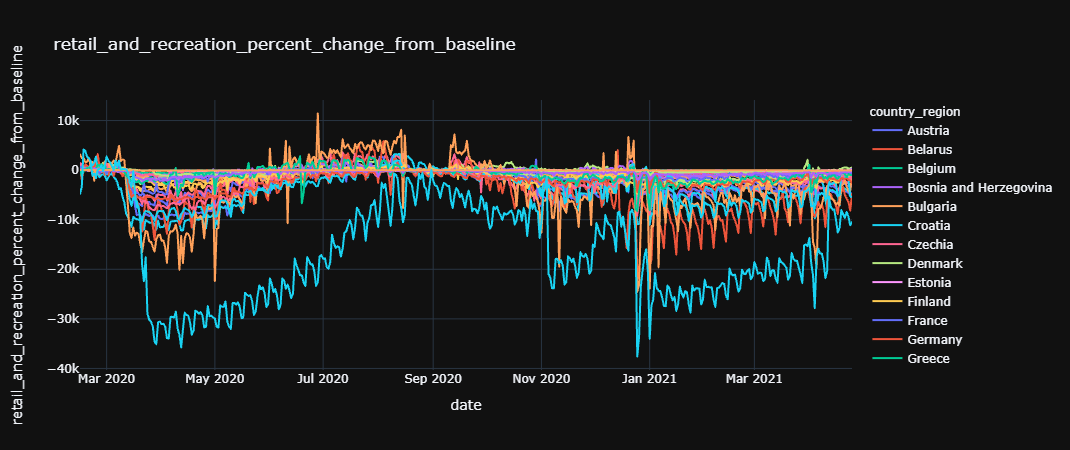

In [10]:
fig = px.line(df, x="date", y="retail_and_recreation_percent_change_from_baseline", color='country_region', 
              title="retail_and_recreation_percent_change_from_baseline")
fig.show()

In [11]:
df_all = df.groupby(['date']).sum()
df_all.reset_index(inplace=True)
df_all

date  retail_and_recreation_percent_change_from_baseline  \
0    2020-02-15                                             5361.0    
1    2020-02-16                                             4779.0    
2    2020-02-17                                            10328.0    
3    2020-02-18                                            12544.0    
4    2020-02-19                                             9294.0    
..          ...                                                ...    
431  2021-04-21                                           -41425.0    
432  2021-04-22                                           -43535.0    
433  2021-04-23                                           -49375.0    
434  2021-04-24                                           -58826.0    
435  2021-04-25                                           -48996.0    

     grocery_and_pharmacy_percent_change_from_baseline  \
0                                                634.0   
1                                              -1266.0   
2                                               5024.0   
3                                               4393.0   
4                                               2225.0   
..                                                 ...   
431                                            22838.0   
432                                            23920.0   
433                                            27269.0   
434                                            18084.0   
435                                            15004.0   

     parks_percent_change_from_baseline  \
0                               10171.0   
1                               -3431.0   
2                               20690.0   
3                               25474.0   
4                               15443.0   
..                                  ...   
431                             38679.0   
432                             41887.0   
433                             47188.0   
434                             66337.0   
435                             66074.0   

     transit_stations_percent_change_from_baseline  \
0                                           8380.0   
1                                           4841.0   
2                                           1476.0   
3                                             74.0   
4                                          -2305.0   
..                                             ...   
431                                       -50923.0   
432                                       -54977.0   
433                                       -51304.0   
434                                       -40705.0   
435                                       -39354.0   

     workplaces_percent_change_from_baseline  \
0                                     -648.0   
1                                    -2152.0   
2                                   -10400.0   
3                                   -15749.0   
4                                   -16340.0   
..                                       ...   
431                                 -74943.0   
432                                 -73759.0   
433                                 -64567.0   
434                                 -14330.0   
435                                 -12449.0   

     residential_percent_change_from_baseline  
0                                      -135.0  
1                                      -273.0  
2                                      2062.0  
3                                      2363.0  
4                                      1940.0  
..                                        ...  
431                                   18678.0  
432                                   19694.0  
433                                   18665.0  
434                                    6593.0  
435                                    4436.0  

[436 rows x 7 columns]

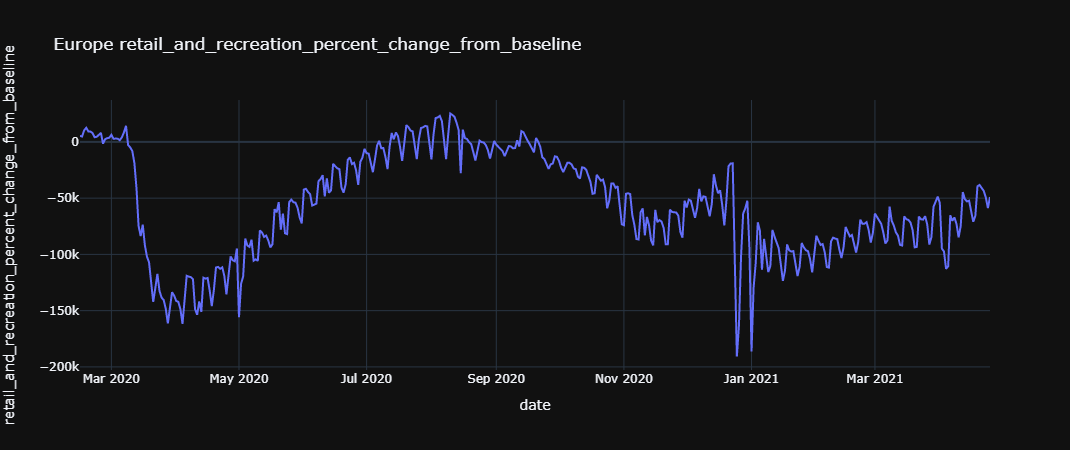

In [12]:
fig = px.line(df_all, x="date", y="retail_and_recreation_percent_change_from_baseline", 
              title="Europe retail_and_recreation_percent_change_from_baseline")
fig.show()

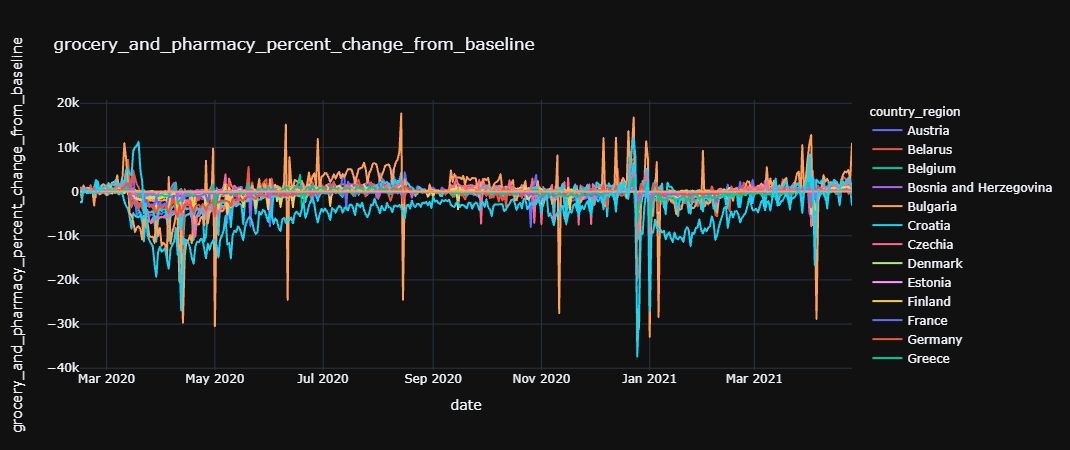

In [13]:
fig = px.line(df, x="date", y="grocery_and_pharmacy_percent_change_from_baseline", color='country_region', 
              title="grocery_and_pharmacy_percent_change_from_baseline")
fig.show()

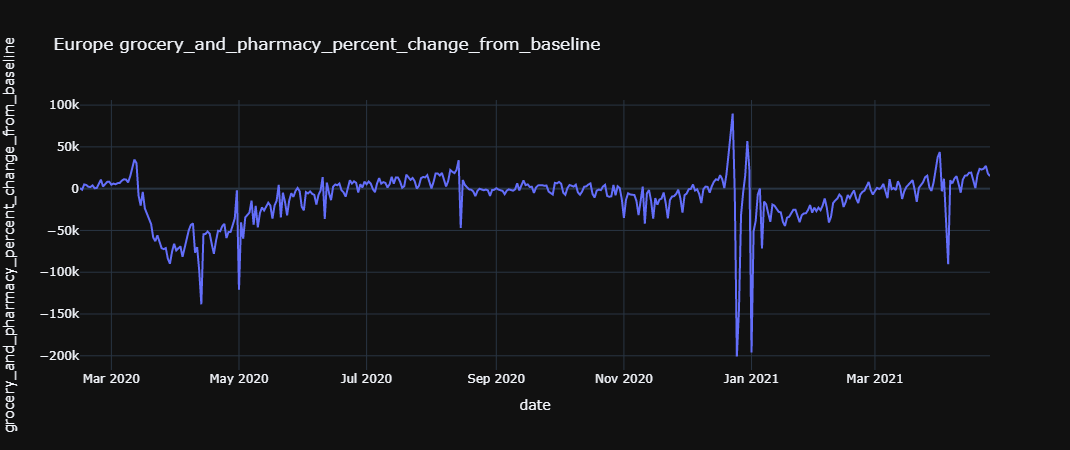

In [14]:
fig = px.line(df_all, x="date", y="grocery_and_pharmacy_percent_change_from_baseline", 
              title="Europe grocery_and_pharmacy_percent_change_from_baseline")
fig.show()

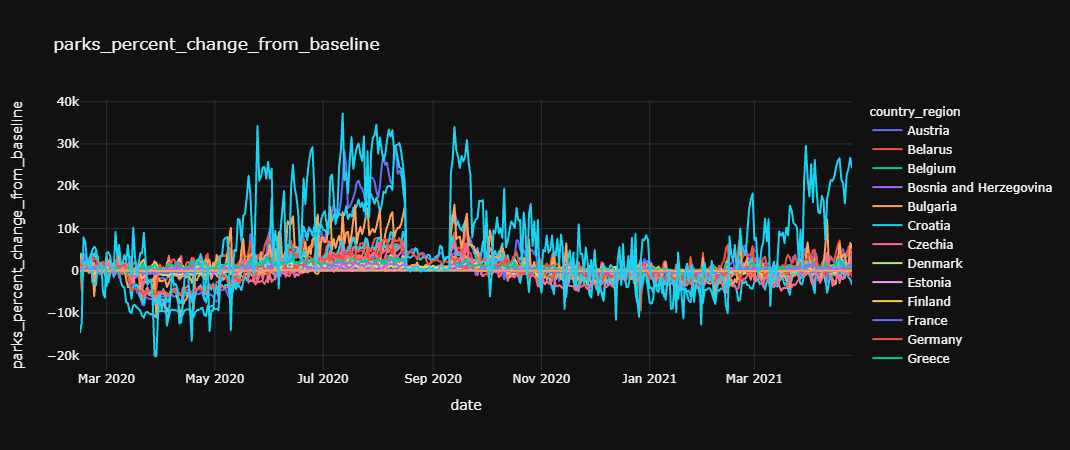

In [15]:
fig = px.line(df, x="date", y="parks_percent_change_from_baseline", color='country_region', 
              title="parks_percent_change_from_baseline")
fig.show()

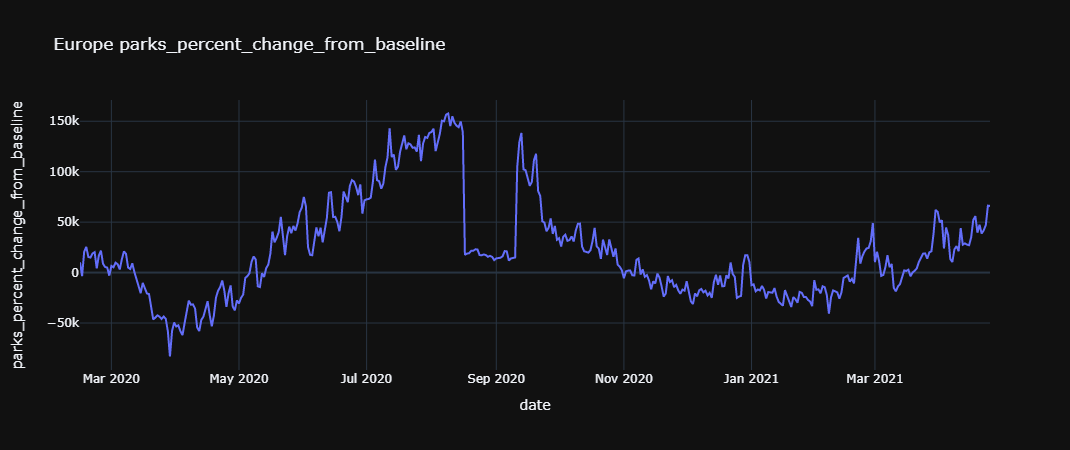

In [16]:
fig = px.line(df_all, x="date", y="parks_percent_change_from_baseline", 
              title="Europe parks_percent_change_from_baseline")
fig.show()

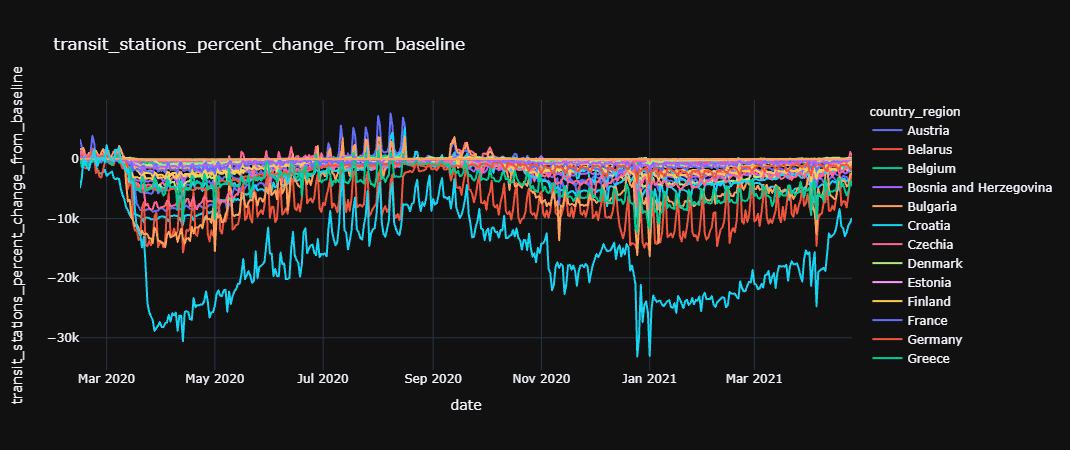

In [17]:
fig = px.line(df, x="date", y="transit_stations_percent_change_from_baseline", color='country_region', 
              title="transit_stations_percent_change_from_baseline")
fig.show()

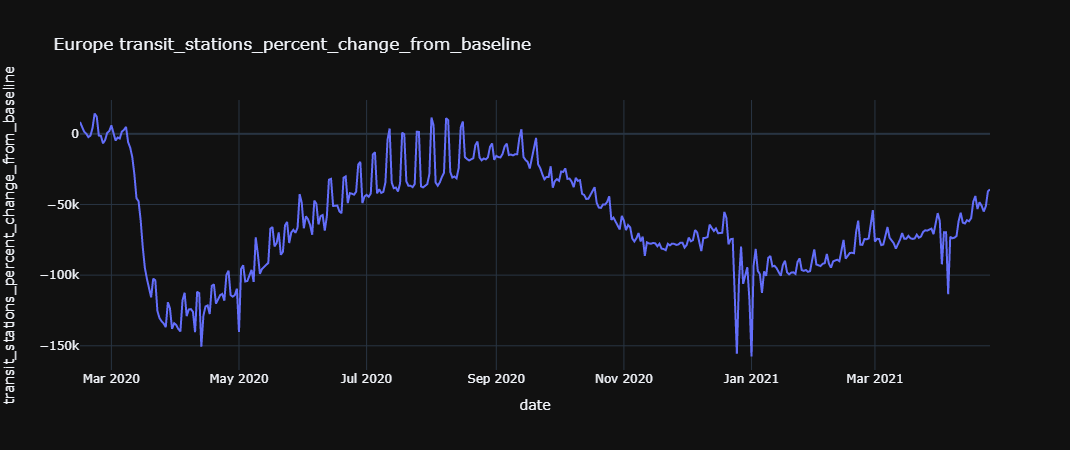

In [18]:
fig = px.line(df_all, x="date", y="transit_stations_percent_change_from_baseline", 
              title="Europe transit_stations_percent_change_from_baseline")
fig.show()

In [19]:
fig = px.line(df, x="date", y="workplaces_percent_change_from_baseline", color='country_region', 
              title="workplaces_percent_change_from_baseline")
fig.show()

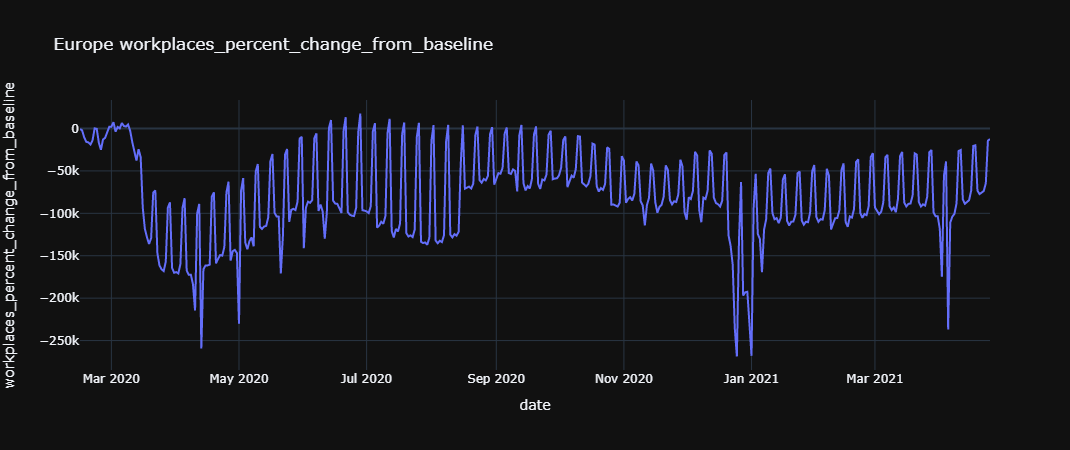

In [20]:
fig = px.line(df_all, x="date", y="workplaces_percent_change_from_baseline", 
              title="Europe workplaces_percent_change_from_baseline")
fig.show()

In [21]:
fig = px.line(df, x="date", y="residential_percent_change_from_baseline", color='country_region', 
              title="residential_percent_change_from_baseline")
fig.show()

In [22]:
fig = px.line(df_all, x="date", y="residential_percent_change_from_baseline", 
              title="Europe residential_percent_change_from_baseline")
fig.show()